PLEASE READ REPORT FOR CNN CODE BACKGROUND INFORMATION AND OTHER COMMENTARY OF EACH LINE OF CODE.

All the code explaination is follow by #
All the alternative code suggestion and detailed explanation is quoted by """. you can remove if you want to rerun this code for clearer visual.

Steps 0. Install package that not presinstalled in Colab environment.

In [4]:
!pip install split-folders  #First install split-folder, since it is not preinstalled with colab
"""  There are other methods to split dataset, for example: use sklearn.train_test_split package, will explain later."""

'  There are other methods to split dataset, for example: use sklearn.train_test_split package, will explain later.'

Steps 1.
These libraries will be used for model building, training, and evaluation.
This model will uses tensorflow as core model tool and image reading tool, OpenCV will be used as Graccam tool. Use split folder for splitting data, confusion matrix, and etc.  Matplotlib still will be used as the main plotting tool.

In [7]:
# Import necessary libraries
import splitfolders  # This is use to split folder to split image datasets

#tensorflow suite for model building
import tensorflow as tf
from tensorflow.keras.models import Sequential  #Use for CNN model consturction
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout #CNN model tool
from tensorflow.keras.preprocessing.image import ImageDataGenerator  #Image reading, manipulation tool
# import cv2; from PIL import Image; from skimage import io;   These three are also popular image reading tool, please also try these
from tensorflow.keras.callbacks import EarlyStopping  # Use to prevent overfitting
from tensorflow.keras.optimizers import Adam  #Optimizer for model training

#from keras.applications.vgg16 import VGG16  #If you want to use a pre-trained model, VGG can be one good alternative.


#SKlearn for confusion matrix and other metrics.
# from sklearn.model_selection import train_test_split     #You can keep this line if you want to use sklearn package to split data
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import roc_curve, auc


#ploting tool
import seaborn as sns
import os
import time  #use to display model training time
import numpy as np
import matplotlib.pyplot as plt

Steps 2. Data import, (mount from Google Drive， you may import from local drive)

In [8]:
# mount drive first and set split folder path
from google.colab import drive
drive.mount('/content/drive') #Give access to google drive
""" My file is saved to google drive, so I mount the drive from google drive folder.
If you file is saved to local drive and you want to use Colab, then you have option to
upload it manually to Google drive, or use following code:
image_path = '/content/drive/MyDrive/XXX/XXX/image.jpg'"""


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


" My file is saved to google drive, so I mount the drive from google drive folder.\nIf you file is saved to local drive and you want to use Colab, then you have option to \nupload it manually to Google drive, or use following code:\nimage_path = '/content/drive/MyDrive/XXX/XXX/image.jpg'"

Steps 3a. Data Processing (Split dataset)

In [ ]:
# set split code to separated cell, so I do have to split folder each time for debugging
input_folder = '/content/drive/MyDrive/Colab Notebooks/All dataset/ImageDataset'  #Set path to original dataset location
output_folder = '/content/drive/MyDrive/Colab Notebooks/All dataset/SplitData'  #Set path to split dataset

# Set split ratio, can be tunned during training
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .2, .1))


""" Here is an example code, just in case if you want to use sklearn package to split the data.
base_dir = '/content/MyDrive/dataset'

# Get the list of image paths and labels
image_paths = []
labels = []

for label in ['Pre-CHF', 'Post-CHF']:
    label_dir = os.path.join(base_dir, label)
    for filename in os.listdir(label_dir):
        image_path = os.path.join(label_dir, filename)
        image_paths.append(image_path)
        labels.append(label)

# Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.1, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.24, random_state=42, stratify=y_train)

CAUTION: This is split to two portions (train and test) and split again (train and validation) method,
means originally split data into test 0.1-10% and train/valid combined 0.9-90%,
then split the train/valid to 0.24*0.9*1500=324 picture for validation, 0.76*0.9*1500=1026 for training
You need to make sure the splitted picture is WHOLE NUMBER! otherwise, you may recieve error message"""


Copying files: 3000 files [04:08, 12.09 files/s]


Steps 3b. Data Processing (Load and augment image data by using ImageDataGenerator from tf.keras)

In [ ]:
# Initialize ImageDataGenerator for data reading and agumentation, I want to use agumentation to make this model more sphosicated and use for other binary classification
# Due to this task too simple, dataset augmentation actually cause severe overfitting, so I turned it off, but want to keep it to test on more complex task.
train_datagen = ImageDataGenerator(rescale=1./255,  # Normalize pixel values to [0, 1]
                                   #rotation_range=30,  # Randomly rotate images up to 30 degrees
                                   #width_shift_range=0.2,  # Randomly shift images horizontally by 20%
                                   #height_shift_range=0.2,  # Randomly shift images vertically by 20%
                                   #horizontal_flip=True  # Randomly flip images horizontally
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Fresh new data for validation, only normalize test images, no augmentation needed
test_datagen = ImageDataGenerator(rescale=1./255)  # Fresh new data for testing, only normalize test images, no augmentation needed

""" As mentioned in the early section, you can also use cv2 to read and resize the image:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
  img = cv2.resize(img, target_size)
  img = img / 255.0

  Or if you also want to augment the image:
add following code behind cv2.imread:

angle = 45 # Define the rotation angle (in degrees)
height, width = img.shape[:2] # Get image dimensions
M = cv2.getRotationMatrix2D((width/2, height/2), angle, 1) # Get rotation matrix
rotated_img = cv2.warpAffine(img, M, (width, height))# Apply the rotation """


Steps 3c. Data Processing (Data resize and read)

In [ ]:
# Define directories for training, validation, and test sets
train_dir = '/content/drive/MyDrive/Colab Notebooks/All dataset/SplitData/train'
valid_dir = '/content/drive/MyDrive/Colab Notebooks/All dataset/SplitData/val'
test_dir = '/content/drive/MyDrive/Colab Notebooks/All dataset/SplitData/test'
""" You can skip this portion if you used sklearn-train-split"""

# Create data generators for train, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize images to 150x150 pixels, Due to the simplicity of the image,
                            # you can reduce size for faster training time.
    batch_size=32,  # Number of images to process in each batch
    class_mode='binary'  # Binary classification (pre-CHF, post-CHF)
)

valid_generator = valid_datagen.flow_from_directory( # Repeat for both validation and test portion
    valid_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important to keep the order of images for evaluation
)

Found 2100 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


Steps 4. Build the CNN Layers    
Define a simple CNN architecture for image classification. Since it's a binary classification task, the final layer will use a sigmoid activation function.

In [10]:
#This cell is to start with CNN layers
model = Sequential()  #Using model.add function to add layers later, to give me flexibility of tuning each layer individually and not affect others.

# Add convolutional layers with Batch Normalization and He Initialization
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=(150, 150, 3)))  # First convolutional layer with 32 filters, and I kept the color at 3, so it can be reused for color image.
model.add(BatchNormalization())  # Apply batch Normalization layer
model.add(Activation('relu'))  # Using reLU activation function, Rectified Linear Unit - popular for most ML or DL model
model.add(MaxPooling2D(pool_size=(2, 2)))  # Max-pooling layer to reduce spatial dimensions
                                          # Pooling size directly dedciated the accuracy and speed of CNN layers
                                          # larger pool size =  faster / coarse feature extraction.
                                          # Smaller pool size = slower / finer feature extraction.

# Second convolutional layer,  even though, 1 CNN layer is enough for this simple task, but I want to make this model more sophiscated.
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adding dropout layer to prevent overfitting
model.add(Dropout(0.5))  # Dropout with a rate of 50%

"""At the end of Section 7, alternative code VGG16 will be given as a pre-trained model refernce"""

'At the end of Section 7, alternative code VGG16 will be given as a pre-trained model refernce'

Steps 5. Flatten CNN outcome.  Dense layer only read 1D Array data, so we need to flatten higher dimension image output.

In [11]:
#This cell is to start with dense layers
# Flatten the output so it can be plug into a 1D vector for the fully connected (dense) layers
model.add(Flatten())

Steps 6: Build Dense layer

In [12]:
# Fully connected layer with Batch Normalization
model.add(Dense(512, kernel_initializer='he_normal'))  # Fully connected layer with 512 neurons
model.add(BatchNormalization())   # Normalization will improve stabilty.
model.add(Activation('relu'))  # Using ReLU as activation function

# Adding dropout layers again to prevent overfitting after dense layer
model.add(Dropout(0.5))  # Dropout with a rate of 50%

In [ ]:
#This is output layer
#Using sigmoid activation for binary classification, can be changed to softmax for categorical
model.add(Dense(1, activation='sigmoid'))  # Output layer with 1 neuron (sigmoid for binary classification)

In [ ]:
# Alternatively you can use VGG16, this is a pre-trained CNN code, the process is extremely simple, you can skip all the
# CNN model set up process. You can also try Inception, and others. Google it.
"""# Load the pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add your custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])"""

Steps 7a. Compile the Model
Compile the model using an appropriate loss function, optimizer, and evaluation metrics.

In [ ]:
# Compile the model with a small Adam learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), #learning rate is a crucial hyperparameter
                                                    # It determine the optimizer steps, too large will cause rapid change in loss value (Bad convergence)
                                                    # Too small will cause slow reduction in loss (Too slow to converge)
              loss='binary_crossentropy', # Crossentropy type loss function is specifically for classification problem.
              metrics=['accuracy'])

In [ ]:
model.summary() #give model summary for intermediate check

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 150, 150, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      21,234,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 21,330,881 (81.37 MB)

 Trainable params: 21,329,409 (81.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

Steps 7b. Start to train the Model with early stopping, so overfitting can be further prevented.

In [ ]:
# Early stopping setup
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#epochs=5 and early stopping enabled means the maximum training duration is limited to 5 epochs
#but training may stop earlier if validation loss stops improving for 5 consecutive epochs

# Train the model
history = model.fit(
    train_generator,  # Training data
    validation_data=valid_generator,  # Validation data
    epochs=5,  # Specifies the maximum number of times the entire training dataset will be passed through the model during training.
              # Too small = underfit, too large = computational expensive and maybe overfit
    callbacks=[early_stopping],  # Early stopping to avoid overfitting
    verbose=1  # Display progress
)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 441s 6s/step - accuracy: 0.9441 - loss: 0.1363 - val_accuracy: 0.5000 - val_loss: 3.8310
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 313ms/step - accuracy: 0.9970 - loss: 0.0079 - val_accuracy: 0.9033 - val_loss: 0.3147
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 313ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 0.0466
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 315ms/step - accuracy: 0.9998 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0058
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 316ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0025


Steps 8. Evaluate the model performance with pre-splitted test dataset.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)  #Test dataset result plot
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 7s/step - accuracy: 1.0000 - loss: 0.0015
Test Loss: 0.0023811229038983583
Test Accuracy: 1.0


Steps 9a. Plot performance and accuracy comparison of each epochs.

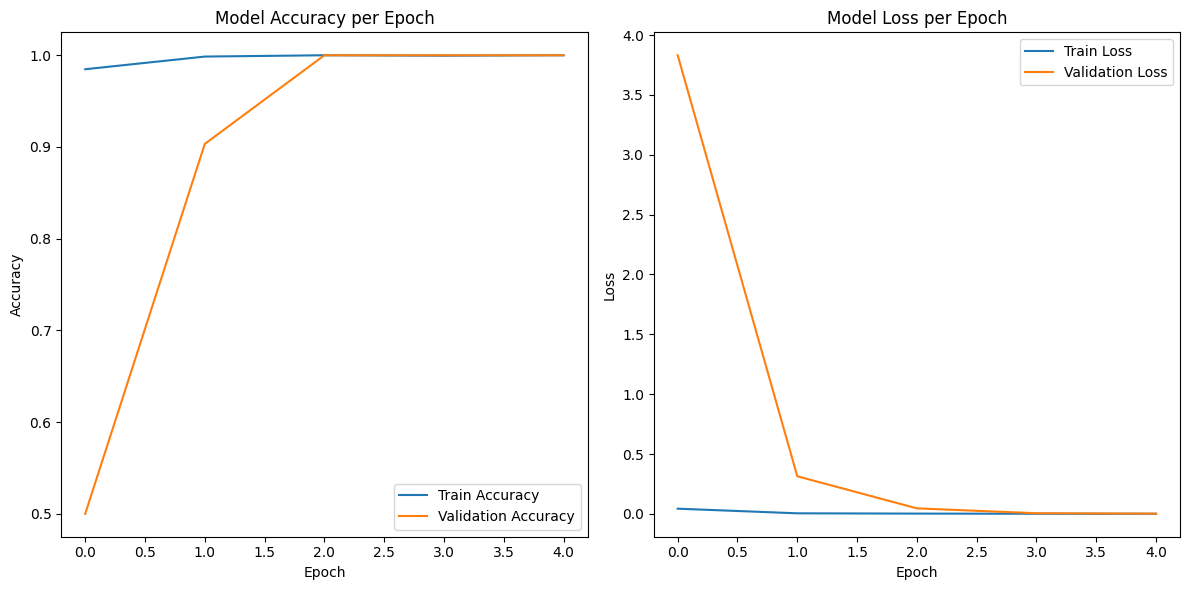

In [ ]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

Steps 9b. Test the model and create confusion matrix / report

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step
Unique values in y_true: [0 1]
Unique values in y_pred: [0 1]


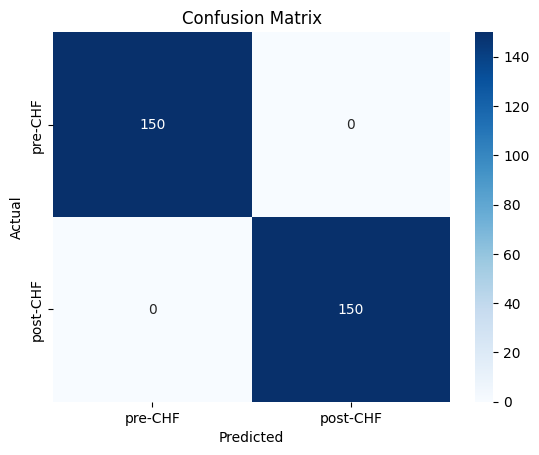

In [ ]:
#start to run test set thru model
Y_pred = model.predict(test_generator)

#Sigmoid probability, less than 0.5 mark 1, larger than 0.5 marh 0
y_pred = np.where(Y_pred > 0.5, 1, 0)

#Annotate class based on test folder
y_true = test_generator.classes

#Check unique values in y_true and y_pred to ensure no extra values
print("Unique values in y_true:", np.unique(y_true))
print("Unique values in y_pred:", np.unique(y_pred))

#Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

#label the the confusion matrix
labels = ['pre-CHF', 'post-CHF']

#Create the heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

#Label the axes and title the plot
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

#print the confusion matrix
plt.show()

Steps 9c. Plot Area under curve and Reciever Operating Charateristic curve

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step


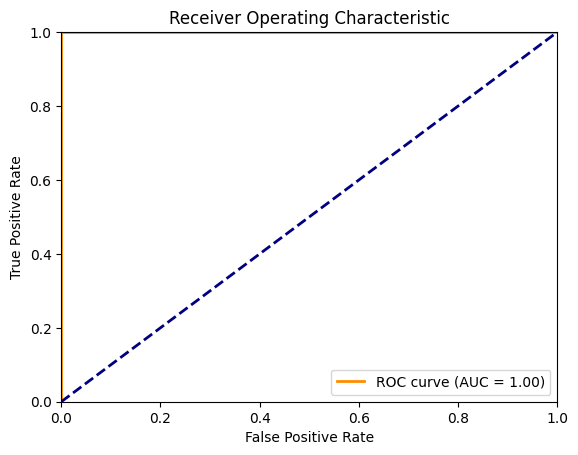

AUC Score: 1.00


In [ ]:
#Generate predicted probabilities on the test set
Y_pred = model.predict(test_generator)  # This will output probabilities

#Get true labels
y_true = test_generator.classes

#Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, Y_pred)  # Use probabilities for ROC curve
roc_auc = auc(fpr, tpr)

#Print the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

#Print AUC score
print(f"AUC Score: {roc_auc:.2f}")